In [ ]:
!pip install numpy==1.23.5

     |████████████████████████████████| 17.1 MB 6.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.13.1 which is incompatible.


In [1]:
pip show numpy tensorflow

Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /home/angana/anaconda3/lib/python3.8/site-packages
Requires: 
Required-by: emcee, ydata-profiling, xgboost, xarray, wordcloud, visions, transformers, tifffile, thinc, tensorflow, tensorboard, tables, sweetviz, streamlit, statsmodels, spacy, soxr, soundfile, seaborn, scipy, scikit-surprise, scikit-learn, scikit-image, PyWavelets, pynverse, pyerfa, pydeck, pyarrow, powerlaw, pingouin, phik, peft, patsy, pandas, opencv-python, onnxruntime, numexpr, numba, mkl-random, mkl-fft, matplotlib, librosa, langchain, langchain-community, imbalanced-learn, imageio, ImageHash, h5py, gym, gradio, gensim, datasets, contourpy, chromadb, chroma-hnswlib, Bottleneck, bokeh, blis, bkcharts, bitsandbytes, astropy, astroML, altair, afterglowpy, accelerate, lmfit, numdifftools, astroquery, grblc
---
Na

In [3]:
# Imports and Setup
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight

### Initial approach

The dataset consists of high-resolution fundus (retina) images ~ around 3000 images, categorized into 5 classesbased on the severity of Diabetic Retinopathy (DR).

- No DR
- Mild
- Moderate
- Severe
- Proliferative DR

Each image is stores in folders named after its DR grade. The images face several challenges such as:
- varying illumination (under/overexposure)
- slight image blur or focus inconsistencies and so on an so forth

**Objective**

We will build a Convolutional Neural Network (CNN) model that can classify fundus images into one of the five DR stages. The model should be:

- Accurate enough to assist in clinical settings,
- Lightweight enough for potential deployment,
- Robust to noise and variability in input images



In [3]:
# Define Paths
DATA_DIR = 'images'  # Folder containing class folders: No DR, Mild, etc.
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 10

### Data preprocessing and augmentation

We use TensorFlow's ImageDataGenerator to perform data preprocessing and augmentation to ensure that the model generalizes well to real-world conditions.

In [ ]:
# Image data augmentation and loading

datagen = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1./255,                    # Normalizes the pixel values
    rotation_range = 15,                 # Simulates the slight camera misalignment
    zoom_range = 0.1,                    # Allows the model learn both the zoomed-in and zoomed-out features
    horizontal_flip=True,                # Handles the anatomical assymetry between right and left eyes
    brightness_range = [0.8, 1.2],       # Simulate under/overexposed images
    shear_range= 0.1,                    # Slight perspective distortion
    width_shift_range = 0.1,
    height_shift_range= 0.1,             # Simulates off center captures
    fill_mode = 'nearest'                # Defines how pixels are filled when image is rotated or shifted
)

# Create a data generator for the training set
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'training'
)

# Create a data generator for the validation set
val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    subset = 'validation'
)



Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


### Model architecture

A simple CNN model is used as a baseline:

- Conv2D + MaxPooling layers to extract features
- Flattening + Dense layers for classification
- Dropout for regularization
- Softmax output layer to predict one of 5 classes

- Loss function: categorical_crossentropy; Optimizer: Adam; Metric: aacuracy

In [5]:
# Define a CNN Model

model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3,3), activation= 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation= 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation= 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation = 'softmax')
])


In [6]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training strategy

- The dataset is split into 80% training and 20% validation using ImageDataGenerator.
- Early stopping is used to prevent overfitting.
- The training is performed on a CPU system for now, using a batch size 0f 16

In [7]:
# Train the model using the training data and validate on the validation data

history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = EPOCHS,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]   # Use EarlyStopping callback to prevent overfitting.
)

Epoch 1/10
184/184 [==============================] - 289s 2s/step - loss: 1.0882 - accuracy: 0.6124 - val_loss: 0.8868 - val_accuracy: 0.6990
Epoch 2/10
184/184 [==============================] - 282s 2s/step - loss: 0.9205 - accuracy: 0.6776 - val_loss: 0.9367 - val_accuracy: 0.6443
Epoch 3/10
184/184 [==============================] - 287s 2s/step - loss: 0.9131 - accuracy: 0.6936 - val_loss: 0.8495 - val_accuracy: 0.6635
Epoch 4/10
184/184 [==============================] - 334s 2s/step - loss: 0.8872 - accuracy: 0.6909 - val_loss: 0.8386 - val_accuracy: 0.6963
Epoch 5/10
184/184 [==============================] - 432s 2s/step - loss: 0.8883 - accuracy: 0.6957 - val_loss: 0.8517 - val_accuracy: 0.6867
Epoch 6/10
184/184 [==============================] - 618s 3s/step - loss: 0.8714 - accuracy: 0.7011 - val_loss: 0.8079 - val_accuracy: 0.7141
Epoch 7/10
184/184 [==============================] - 768s 4s/step - loss: 0.8719 - accuracy: 0.7039 - val_loss: 0.8611 - val_accuracy: 0.6936

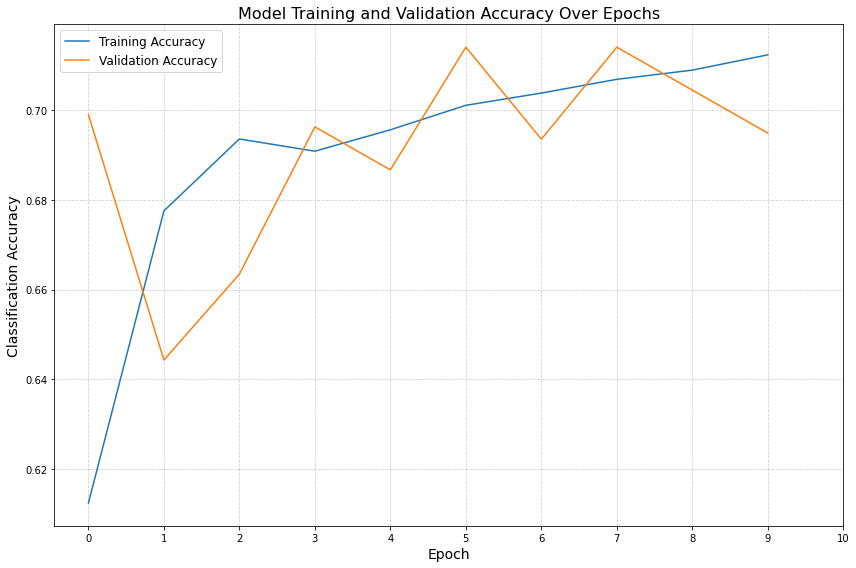

In [10]:
# Plot the training and validation accuracy over epochs 
plt.figure(figsize = (12,8))
epochs = np.arange(0, len(history.history['accuracy']) + 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Classification Accuracy', fontsize=14)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

The plot shows a model that learns well from the training data. However, it starts to overfit after a certain number of epochs, as indicated by the declining validation accuracy while the training accuracy continues to improve. This highlights the importance of monitoring validation metrics to prevent overfitting and to select the model that generalizes best.

In [9]:
# Replace CNN with a pre-trained model

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False, 
    weights='imagenet'
)

base_model.trainable = False #Freezes the base model initially

model =models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(train_generator.num_classes, activation = 'softmax')
])


In [11]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y = train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

In [13]:
# Train the model using the training data and validate on the validation data

history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)]   # Use EarlyStopping callback to prevent overfitting.
)

Epoch 1/10
184/184 [==============================] - 237s 1s/step - loss: 1.5615 - accuracy: 0.5493 - val_loss: 1.5120 - val_accuracy: 0.3803
Epoch 2/10
184/184 [==============================] - 140s 760ms/step - loss: 1.2495 - accuracy: 0.5824 - val_loss: 0.7821 - val_accuracy: 0.6498
Epoch 3/10
184/184 [==============================] - 157s 855ms/step - loss: 1.1660 - accuracy: 0.6141 - val_loss: 0.8493 - val_accuracy: 0.6279
Epoch 4/10
184/184 [==============================] - 149s 811ms/step - loss: 1.1258 - accuracy: 0.6138 - val_loss: 0.7582 - val_accuracy: 0.6990
Epoch 5/10
184/184 [==============================] - 140s 760ms/step - loss: 1.0865 - accuracy: 0.6486 - val_loss: 0.8001 - val_accuracy: 0.6621
Epoch 6/10
184/184 [==============================] - 140s 763ms/step - loss: 1.0693 - accuracy: 0.6421 - val_loss: 0.8026 - val_accuracy: 0.6621
Epoch 7/10
184/184 [==============================] - 128s 695ms/step - loss: 1.0405 - accuracy: 0.6373 - val_loss: 0.7286 - va

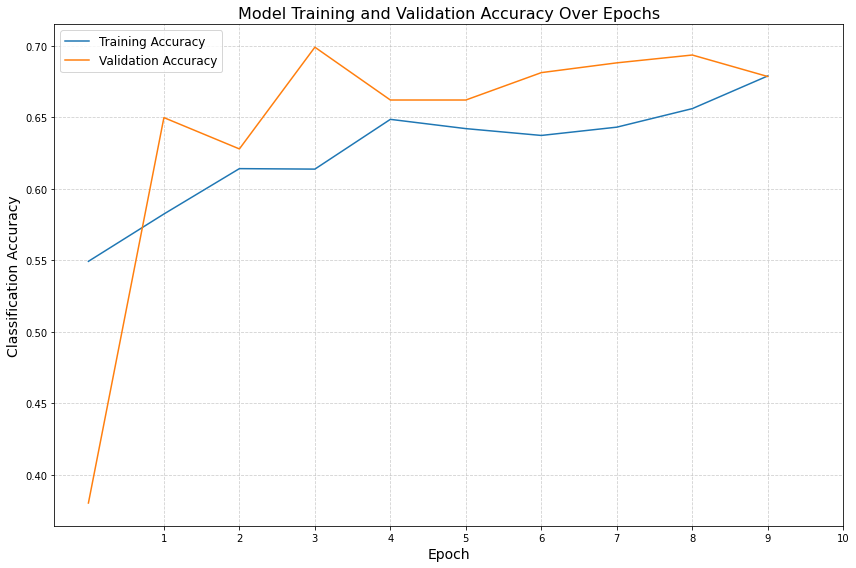

In [14]:
# Plot the training and validation accuracy over epochs 
plt.figure(figsize = (12,8))
epochs = np.arange(1, len(history.history['accuracy']) + 1)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Classification Accuracy', fontsize=14)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Positive improvements:

- Validation accuracy is consistently higher than training accuracy: This suggests that the model is generalizing well and not overfitting to the training data, which is a good sign, especially given the class imbalance.

- Both accuracies improve over epochs: There is a clear upward trend in both training and validation accuracy, indicating effective learning.

- Smaller gap between curves: The gap between training and validation accuracy is not large, suggesting that the model is not suffering from severe overfitting or underfitting.

### Areas for Further Improvement

Both training and validation accuracy plateau below 0.70. While this is an improvement, there is still room for boosting performance, especially for a medical diagnosis problem where higher accuracy is desirable. There is some fluctuation in validation accuracy, especially in the first few epochs. This can be due to:

- Small validation set size (leading to higher variance).

- The model still adjusting to the class weights and the new architecture.



The changes have clearly improved model performance and stability. The use of a pre-trained model and class weighting has helped address the initial issues. With further fine-tuning and targeted augmentation, we can achieve even better results, especially for underrepresented classes. 

---
